In [1]:
# install.packages("GGally")   # Uncomment this line if GGally is not installed
install.packages("caret")
install.packages('e1071', dependencies=TRUE)
library(tidyverse)
library(caret)
library(ggplot2)
library(GGally)
library(repr)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mlbench’, ‘slam’


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:dplyr’:

    nasa




# Predicting Tennis Match Winners

**Course:** DSCI 100 | Term 2 | 2019W

**Submitted by:**
* Jerry Hall
* Nic Tavares
* Jennifer Zhang
* Huy Pham

# 1 Introduction

The US Open grand slam tennis tournament has an estimated total prize money pool of USD $50.4 million. This puts it in line with high-value tournaments such as the MLB World Series and the PGA FedEx Cup (source: pledgesports.org). With such a high potential payoff, there is much incentive for competitive tennis athletes, coaches and potential sponsors to understand the player attributes that contribute to tournament success. 

This project will study the data of tennis match results collected for the top 500 tennis players from 2017-2019. The purpose of the study is to determine whether certain attributes contribute to greater competitive success by analyzing player and match information. In addition, this analysis will also verify the accuracy of hypothesis made by academic scholars. For example, according to Sports Mechanics journal, height significantly affects players' serve speed, which in turn boost his winning chance. Another common claim is there is "prime" age ranging from 27 to 31, in which players perform at their very peak<sup>1, 2</sup>.

We hope to find the answers to these questions by analyzing a comprehensive dataset contains results from nearly 7,000 matches and includes the winner and loser heights, playing hands, countries of origin, ages, match times and other information (source: https://github.com/JeffSackmann/tennis_atp).

> **Comments:**   
> `identify and describe the dataset that was used to answer the question`
> - Maybe a bit more info to describe the dataset?
> - Jerry's source for the intro was: `https://www.pledgesports.org/2017/09/10-sporting-events-with-the-biggest-prize-money/`

# 2 Methods


### 2.1 Loading Data

The tennis player data available on Jeff Sackmann's GitHub<sup>**ADD THIS!!!!**</sup> is split into CSV files per year. To begin, we will use the read_csv() function to scrape the data from the web and use rbind() to combine the three dataframes into a single one.

In [2]:
data2017 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv', col_types = cols())
data2018 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2018.csv', col_types = cols())
data2019 <- read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv', col_types = cols())

combined_data <- rbind(data2017, data2018, data2019)

### 2.2 Wrangling and Cleaning Data

Next, we select the columns that we are interested in and tidy the data based on whether the given match result was a win or loss.

In [3]:
tennis <- combined_data %>% 
    select(winner_hand, loser_hand, winner_age, loser_age, winner_ht, loser_ht, minutes, w_ace, l_ace)

tennis_win = select(tennis, winner_hand, winner_age, winner_ht, minutes, w_ace)
tennis_loss = select(tennis, loser_hand, loser_age, loser_ht, minutes, l_ace)

tennis_win = mutate(tennis_win, hand = winner_hand, age = winner_age, height = winner_ht, aces = w_ace, result = 'w') %>%
            select(-winner_hand, -winner_age, -winner_ht, -w_ace)
tennis_loss = mutate(tennis_loss, hand = loser_hand, age = loser_age, height = loser_ht, aces = l_ace, result = 'l') %>%
            select(-loser_hand, -loser_age, -loser_ht, -l_ace)

cleaned_data = rbind(tennis_win, tennis_loss)

The match result is then converted to a factor. This allows us to categorize each match winner and loser. The results of this categorization is shown below.

In [4]:
cleaned_data = mutate(cleaned_data, result = as.factor(result))
rows = sample(nrow(cleaned_data))
cleaned_data = cleaned_data[rows, ]

head(cleaned_data)

minutes,hand,age,height,aces,result
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
76,R,22.89391,NA,4,w
149,R,25.85626,NA,8,w
60,R,32.20260,196,3,l
95,R,22.89391,NA,8,l
100,R,31.89049,193,0,w
87,R,27.84120,NA,7,w


Next, we separate the tidied data into a training_set and a testing_set. The training_set will be given 0.75 of the cleaned_data set; testing_set will be given 0.25. This is so that our model is trained against the training set and we can later perform cross-validation with a testing set to find an optimal k-value.

We will use the createDataPartition() function and the slice() function to split the data into two sets.

In [5]:
set.seed(42)

training_rows <- cleaned_data %>%
    select(result) %>% 
    unlist() %>%
    createDataPartition (p = 0.75 , list = FALSE)

training_set <- cleaned_data %>% slice (training_rows) %>% na.omit()
testing_set <- cleaned_data %>% slice (-training_rows) %>% na.omit()

### 2.3 Data Summar

Now that the sets have been partitioned, we plot a matrix of the parameters that which we will later use to perform analysis of predicted player match outcomes.

There are two goals we want to achieve with our visualization:

The correlation between our predicting variables. If one variable is highly correlated to another, we may eliminate them and simplify the modelling process.
The correlation between our predicting variables with our labeling variables.
We achieve this by using the ggpair() and ggcorr() functions. While ggpair() gives us a comprehensive view of how each variable correlates to each other through histograms, box plots, regression model and more, ggcorr() provides a more straightforward matrix with results of correlation between variables

Warning message:
“Ignoring unknown parameters: title”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



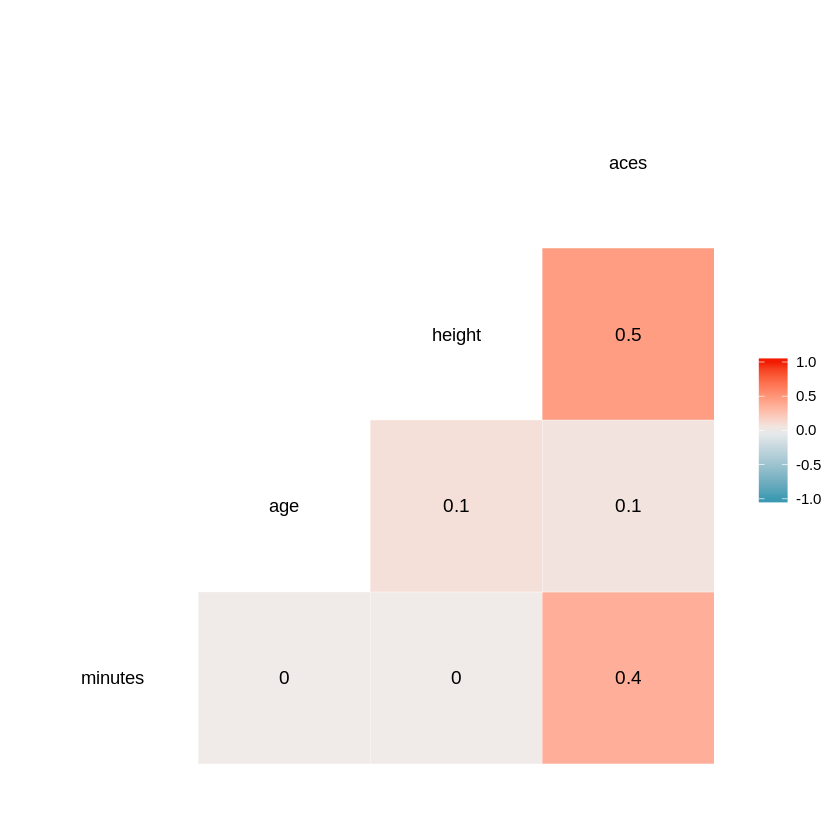

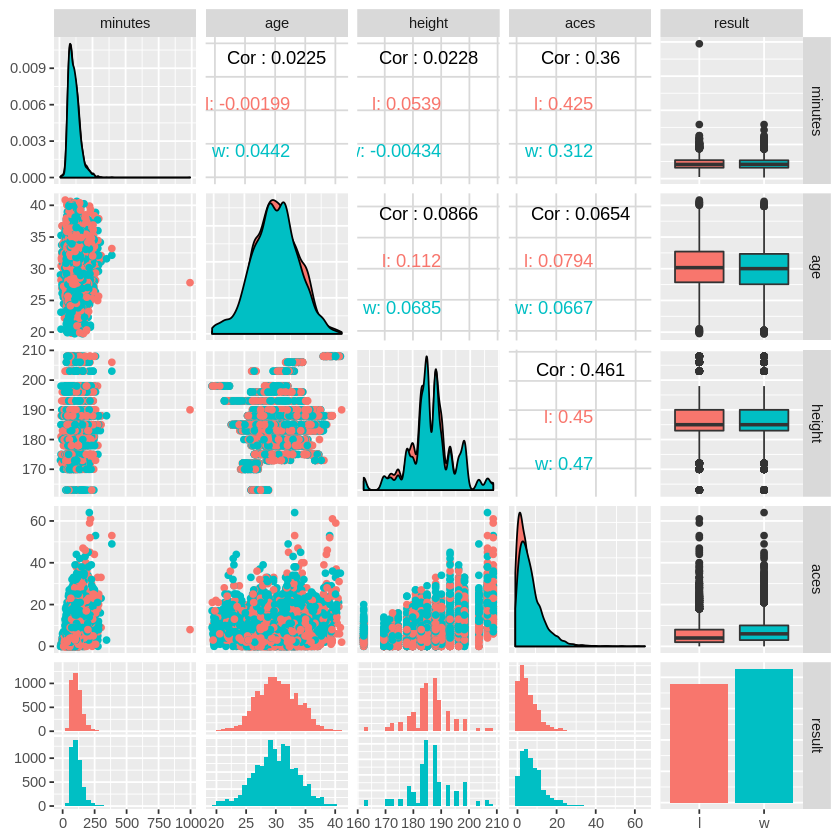

In [6]:
options (repr.plot.width=7, repr.plot.height=7)
tennis_matrix_train <- ggcorr(select(training_set, -hand, -result), label = TRUE, title = "Training Data Correlations", )
tennis_matrix_train

training_set2 = select(training_set, -hand)
tennis_train_pairs = ggpairs(training_set2, columns = 1:5, ggplot2::aes(colour=result), progress = FALSE)
tennis_train_pairs

After the first plots we create some basic tables to look at the number of left handed players vs right handed players - which shows that there are way more right handed players which is something to keep in mind later. Then we create a table that shows the mean value of each of the predictor variables we are using.

In [7]:
training_table = group_by(training_set, hand) %>%
    summarize(count = n())
training_table


quantitative_summary_table <- training_set %>% 
                             select(minutes, age, height, aces) %>%
                             map_df (~mean(., na.rm = TRUE)) 
quantitative_summary_table

hand,count
<chr>,<int>
L,1197
R,6870


minutes,age,height,aces
<dbl>,<dbl>,<dbl>,<dbl>
111.2085,30.12936,186.3126,6.906285


In order to perform k-nn classification we first need to alter the hand column to be numeric and not categorical and then we need to scale our data so that we don't over or under weight certain characteristics based on the unit they were measured in. We have arbitrarily chosen 1 to represent right handed and 0 to represent left handed.

In [8]:
training_data_scaled = training_set %>% mutate(hand = ifelse(hand == "R", 1, 0))

training_data_scaled = training_data_scaled %>% 
                        mutate(minutes = scale(minutes, center = TRUE)) %>%
                        mutate(age = scale(age, center = TRUE)) %>%
                        mutate(height = scale(height, center = TRUE)) %>%
                        mutate(aces = scale(aces, center = TRUE))

testing_data_scaled = testing_set %>% mutate(hand = ifelse(hand == "R", 1, 0))

testing_data_scaled = testing_data_scaled %>% 
                        mutate(minutes = scale(minutes, center = TRUE)) %>%
                        mutate(age = scale(age, center = TRUE)) %>%
                        mutate(height = scale(height, center = TRUE)) %>%
                        mutate(aces = scale(aces, center = TRUE))



head(training_data_scaled)
head(testing_data_scaled)
                    

minutes,hand,age,height,aces,result
"<dbl[,1]>",<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
-1.19016128,1,0.5828788,1.2394999,-0.6385144,l
-0.26050219,1,0.4951295,0.8556495,-1.1288891,w
-0.49291696,1,0.7914757,0.8556495,-0.8019726,l
0.08811997,1,-0.3669684,1.2394999,1.3229844,l
-0.60912435,0,1.5735217,0.2158990,0.1787767,w
-0.91126355,1,1.6689683,-0.4238516,-1.1288891,l


minutes,hand,age,height,aces,result
"<dbl[,1]>",<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
1.0429007,0,-0.54026084,-0.1717519,-0.10780847,w
-1.1770172,1,-2.36603518,1.4931886,-0.78727466,l
-0.7712258,1,-0.03791164,-0.4278965,-0.78727466,l
-0.2938241,1,-0.87466268,-0.1717519,0.06205808,w
-0.9860565,1,1.36538180,0.2124652,-1.12700776,l
-0.6041352,1,-0.30513454,-0.1717519,-0.78727466,l


Now we will split the data into:
* X_train
* X_test
* Y_train
* Y_test


In [9]:
X_train = training_data_scaled %>%
        select(-result) %>%
        data.frame()

Y_train = training_data_scaled %>%
        select(result) %>%
        unlist()

X_test = testing_data_scaled %>%
        select(-result) %>%
        data.frame()

Y_test = testing_data_scaled %>%
        select(result) %>%
        unlist()
            

Now we will be using our training data to build a model. First thing we need to do is choose a number k that represents the number of neighbors we will be examining in order to determine the classification of a new data point. We will be evaluating k in the range of 1:20 and using 10 fold cross validation.

In [12]:
ks = data.frame(k = c(1:20))
train_control <- trainControl(method = "cv", number = 10)
choose_k = train(x = X_train, y = Y_train, method = "knn", tuneGrid = ks, trControl = train_control)
choose_k


k-Nearest Neighbors 

8067 samples
   5 predictor
   2 classes: 'l', 'w' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7260, 7261, 7260, 7261, 7261, 7260, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa     
   1  0.5413459  0.07949688
   2  0.5419622  0.08101589
   3  0.5558505  0.10765936
   4  0.5557284  0.10688988
   5  0.5621742  0.11940453
   6  0.5680018  0.13148272
   7  0.5713444  0.13768834
   8  0.5732021  0.14135629
   9  0.5753105  0.14531982
  10  0.5733272  0.14161248
  11  0.5797734  0.15425565
  12  0.5818839  0.15872026
  13  0.5812600  0.15758654
  14  0.5758043  0.14618410
  15  0.5793989  0.15323020
  16  0.5743153  0.14294367
  17  0.5803910  0.15522454
  18  0.5796475  0.15381793
  19  0.5818796  0.15834511
  20  0.5795267  0.15333517

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 12.

Now we can plot the accuracies for our various k values.

,k,Accuracy
,<int>,<dbl>
1,1,0.5413459
2,2,0.5419622
3,3,0.5558505
4,4,0.5557284
5,5,0.5621742
6,6,0.5680018
7,7,0.5713444
8,8,0.5732021
9,9,0.5753105


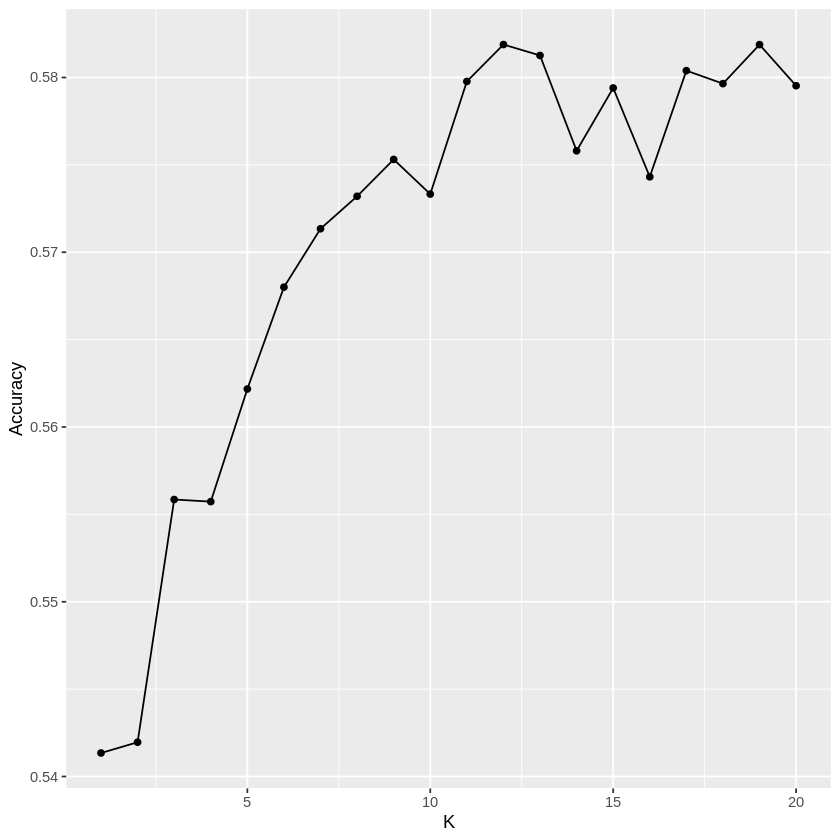

In [13]:
k_accuracies_again <- choose_k$results %>% select(k, Accuracy)
k_accuracies_again
choose_k_again_plot <- ggplot(k_accuracies_again, aes(x = k, y = Accuracy)) +
                          geom_line() +
                          geom_point() +
                            labs(x = "K", y = "Accuracy")


# your code here
choose_k_again_plot

As we can see from plot - k = 12 gives us the highest accuracy out of the values we tested. Therefore we will choose k = 12 for our model.

In [15]:
final_k = data.frame(k = 12)
final_classifier <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = final_k)
final_classifier

k-Nearest Neighbors 

8067 samples
   5 predictor
   2 classes: 'l', 'w' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 8067, 8067, 8067, 8067, 8067, 8067, ... 
Resampling results:

  Accuracy   Kappa    
  0.5621367  0.1191706

Tuning parameter 'k' was held constant at a value of 12

Now we can test the accuracy of our model using the testing set data that we split off earlier.

In [16]:
test_pred <- predict(final_classifier, X_test)
test_results <- confusionMatrix(test_pred, Y_test)
test_results

Confusion Matrix and Statistics

          Reference
Prediction   l   w
         l 641 522
         w 620 894
                                          
               Accuracy : 0.5734          
                 95% CI : (0.5544, 0.5922)
    No Information Rate : 0.529           
    P-Value [Acc > NIR] : 2.125e-06       
                                          
                  Kappa : 0.1403          
                                          
 Mcnemar's Test P-Value : 0.0041          
                                          
            Sensitivity : 0.5083          
            Specificity : 0.6314          
         Pos Pred Value : 0.5512          
         Neg Pred Value : 0.5905          
             Prevalence : 0.4710          
         Detection Rate : 0.2394          
   Detection Prevalence : 0.4344          
      Balanced Accuracy : 0.5698          
                                          
       'Positive' Class : l               
                              

# Citation

1. César Gallo-Salazar, Juan José Salinero, David Sanz, Francisco Areces & Juan del Coso (2015). Professional tennis is getting older: Age for the top 100 ranked tennis players. International Journal of Performance Analysis in Sport, 15:3, 873-883, DOI: 10.1080/24748668.2015.11868837

2. Vaverka, Frantisek & Cernosek, Miroslav (2013). Association between body height and serve speed in elite tennis players. Sports Biomech, 12, 30-7, DOI: 10.1080/14763141.2012.670664. 